## Beskrivelse av Plotting av data

Denne Jupyter Notebook inneholder flere seksjoner som analyserer og visualiserer miljødata fra ulike kilder som temperatur, nedbør, vindhastighet og luftfuktighet. Her er en oversikt over hva koden gjør:

---

### 1. **Importering av nødvendige biblioteker**
Koden starter med å importere nødvendige biblioteker for dataanalyse, maskinlæring og visualisering:
- `matplotlib.pyplot` og `plotly.graph_objects` for plotting.
- `pandas` for datahåndtering.
- `sklearn` for maskinlæringsmodeller og dataskalering.

---

### 2. **Analyse, visualisering og forecasting av temperaturdata**
- **Lese data**: Temperaturdata lastes inn fra en CSV-fil.
- **Dataprosessering**:
  - Konverterer `referenceTime` til datetime-format.
  - Fjerner rader med ugyldige tidsverdier.
- **Maskinlæring**:
  - Data splittes i trenings- og testsett.
  - Data skaleres med `StandardScaler`.
  - En lineær regresjonsmodell trenes og brukes til å predikere temperaturverdier.
- **Visualisering**:
  - Faktiske verdier og prediksjoner plottes med `matplotlib`.
  - Feil mellom faktiske og predikerte verdier vises som stiplete linjer.
  - Gjennomsnittlig absolutt feil (MAE) og R²-verdi beregnes og skrives ut.

---

### 3. **Visualisering av temperatur, nedbør, vindhastighet og luftfuktighet**
- **Gruppere data**: Nedbørsdata grupperes månedlig for å redusere antall søyler i plottet.
- **Visualisering**:
  - Bruker `plotly.graph_objects` for å lage et stolpediagram.
  - Gjennomsnittlig og median nedbør vises som stiplete linjer i plottet.

---

### Viktige beregninger
- **Gjennomsnitt og median**: Beregnes for hver datakilde og brukes i visualiseringene.
- **Feilmålinger**: MAE og R²-verdi brukes for å evaluere modellens ytelse.

---

### Visualiseringsteknikker
- `matplotlib` brukes for å vise faktiske verdier og prediksjoner med feillinjer.
- `plotly` brukes for interaktive grafer som linjediagrammer og stolpediagrammer.

---

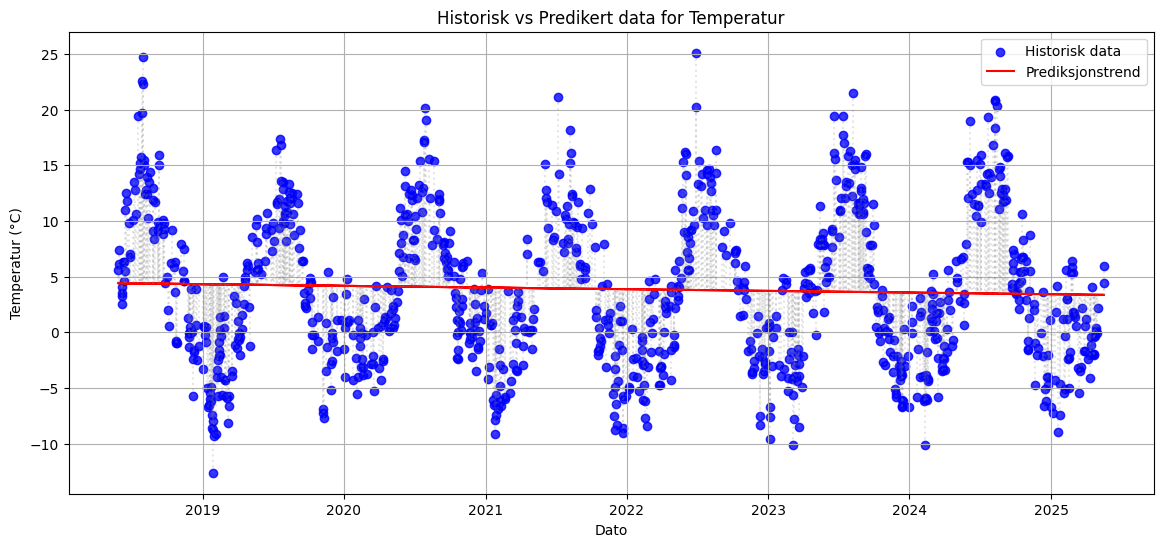

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Les inn data
temperature_data = pd.read_csv("../data/temperature_data.csv")

# Konverter referenceTime til datetime
temperature_data['referenceTime'] = pd.to_datetime(temperature_data['referenceTime'], errors='coerce')

# Fjern rader med NaT i referenceTime
temperature_data = temperature_data.dropna(subset=['referenceTime'])

X_regn = temperature_data['referenceTime']
Y_regn = temperature_data['value']

# Splitter dataene i trenings- og testsett
X_train, X_test, y_train, y_test = train_test_split(X_regn, Y_regn, test_size=0.2, random_state=0)

# Omformer dataene til 2D-arrays
X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)

# Behold en kopi av de opprinnelige datoene for plotting
X_test_dates = X_test.flatten()

# Skalering
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Trene en lineær regresjonsmodell og gjøre prediksjoner på testsettet
regr = LinearRegression()
regr.fit(X_train_scaled, y_train)

# Predikere på testsettet
y_pred = regr.predict(X_test_scaled)

# Tilbakestill indeksen for y_test
y_test_reset = y_test.reset_index(drop=True)

# Visualiserer prediksjoner vs faktiske verdier med datoer på x-aksen
plt.figure(figsize=(14, 6))

# Plot historiske data
plt.scatter(X_test_dates, y_test_reset, color='blue', label='Historisk data', alpha=0.8)

# Plot prediksjonstrend
plt.plot(X_test_dates, y_pred, color='red', label='Prediksjonstrend')

# Legg til stiplete linjer for å vise avvik mellom faktiske og predikerte verdier
for i in range(len(X_test_dates)):
    plt.plot([X_test_dates[i], X_test_dates[i]],
             [y_test_reset[i], y_pred[i]], color='Gray', linestyle='dotted', alpha=0.2)

# Legg til tittel og akseetiketter
plt.title('Historisk vs Predikert data for Temperatur')
plt.xlabel('Dato')
plt.ylabel('Temperatur (°C)')
plt.legend()
plt.grid(True)
plt.show()

Her ser man en tydelig trend i regresjonslinjen. Gjennomsnittstemperaturen har sunket i løpet av de siste 7 årene. Dette er ikke en bra måte for å predikere fremtiden, ettersom at den ikke tar sesongvariasjonen i betraktning. 

Mean Squared Error (MSE) on Test Set: 15.744


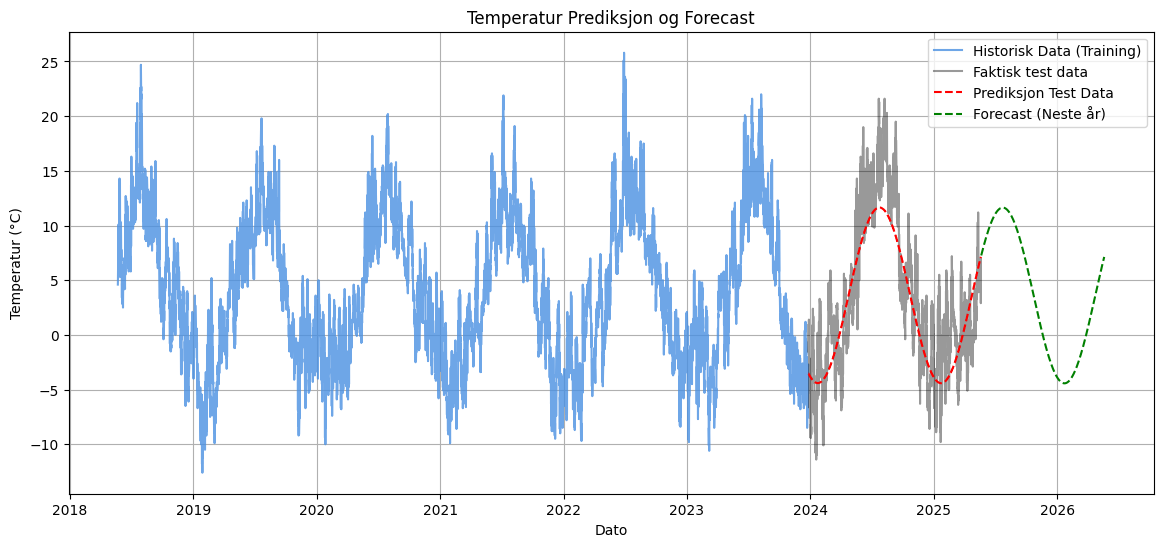

In [2]:
# Import necessary libraries
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

# Load temperature data
temperature_data = pd.read_csv("../data/temperature_data.csv")

# Convert referenceTime to datetime
temperature_data['referenceTime'] = pd.to_datetime(temperature_data['referenceTime'], errors='coerce')

# Drop rows with invalid datetime values
temperature_data = temperature_data.dropna(subset=['referenceTime'])

# Feature Engineering: Add day count and seasonality features
temperature_data['Day'] = (temperature_data['referenceTime'] - temperature_data['referenceTime'].min()).dt.days
temperature_data['Sin_Day'] = np.sin(2 * np.pi * temperature_data['Day'] / 365)
temperature_data['Cos_Day'] = np.cos(2 * np.pi * temperature_data['Day'] / 365)

# Split into training and testing sets
train_size = int(0.8 * len(temperature_data))
train = temperature_data.iloc[:train_size]
test = temperature_data.iloc[train_size:]

X_train = train[['Day', 'Sin_Day', 'Cos_Day']]
y_train = train['value']

X_test = test[['Day', 'Sin_Day', 'Cos_Day']]
y_test = test['value']

# Train Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE) on Test Set: {mse:.3f}")

# Generate future dates for the next year
future_days = 365
last_day = temperature_data['referenceTime'].max()
future_dates = pd.date_range(start=last_day + pd.Timedelta(days=1), periods=future_days)

# Create a DataFrame for future dates
future_data = pd.DataFrame({'referenceTime': future_dates})
future_data['Day'] = (future_data['referenceTime'] - temperature_data['referenceTime'].min()).dt.days
future_data['Sin_Day'] = np.sin(2 * np.pi * future_data['Day'] / 365)
future_data['Cos_Day'] = np.cos(2 * np.pi * future_data['Day'] / 365)

# Predict future temperatures
X_future = future_data[['Day', 'Sin_Day', 'Cos_Day']]
future_data['Predicted_Temperature'] = model.predict(X_future)

# Plot the results including the forecast
plt.figure(figsize=(14, 6))

# Plot historical data (training data only) with a warmer blue
plt.plot(train['referenceTime'], y_train, label='Historisk Data (Training)', color='#4a90e2', alpha=0.8)

# Plot actual test data
plt.plot(test['referenceTime'], y_test, label='Faktisk test data', color='black', alpha=0.4)

# Plot predicted test data
plt.plot(test['referenceTime'], y_pred, label='Prediksjon Test Data', linestyle='--', color='red')

# Plot forecast for the next year
plt.plot(future_data['referenceTime'], future_data['Predicted_Temperature'], label='Forecast (Neste år)', linestyle='--', color='green')

# Add title and labels
plt.title('Temperatur Prediksjon og Forecast')
plt.xlabel('Dato')
plt.ylabel('Temperatur (°C)')
plt.legend()
plt.grid(True)
plt.show()


Dette er et forsøk på å bedre predikere gjennomsnittstemperaturen det neste året enn en lineær regresjon. Her følger prediksjonen sesongvariasjonen.

In [3]:
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt


# Leser data fra de separate CSV-filene
temperature_data = pd.read_csv("../data/temperature_data.csv")
precipitation_data = pd.read_csv("../data/precipitation_data.csv")
wind_speed_data = pd.read_csv("../data/wind_speed_data.csv")
humidity_data = pd.read_csv("../data/humidity_data.csv")

# Konverterer referansetiden til datetime for alle datasettene
temperature_data['referenceTime'] = pd.to_datetime(temperature_data['referenceTime'])
precipitation_data['referenceTime'] = pd.to_datetime(precipitation_data['referenceTime'])
wind_speed_data['referenceTime'] = pd.to_datetime(wind_speed_data['referenceTime'])
humidity_data['referenceTime'] = pd.to_datetime(humidity_data['referenceTime'])

# Plotter temperaturdata
fig_temp = go.Figure()
fig_temp.add_trace(go.Scatter(
    x=temperature_data['referenceTime'],
    y=temperature_data['value'],
    mode='lines',
    name='Temperatur',
    line=dict(color='#1f77b4')
))
mean_temp = temperature_data['value'].mean()
median_temp = temperature_data['value'].median()
fig_temp.add_trace(go.Scatter(
    x=temperature_data['referenceTime'],
    y=[mean_temp] * len(temperature_data['referenceTime']),
    mode='lines',
    line=dict(dash='dash', color='rgba(31, 119, 180)'),
    name='Gjennomsnittstemperatur'
))
fig_temp.update_layout(
    title=f"Temperatur over tid<br>Gjennomsnitt: {mean_temp:.2f} °C, Median: {median_temp:.2f} °C",
    xaxis_title="Dato",
    yaxis_title="Temperatur (°C)"
)
fig_temp.show()

Linjediagrammet er en effektiv måte å visualisere data på, da det gir en tydelig oversikt over temperaturutviklingen over tid. Vi valgte å bruke linjediagram fordi det er en av de vanligste metodene for datavisualisering, og vi mente det gir en god og lettfattelig framstilling av informasjonen, samtidig som det ser ryddig og estetisk ut.

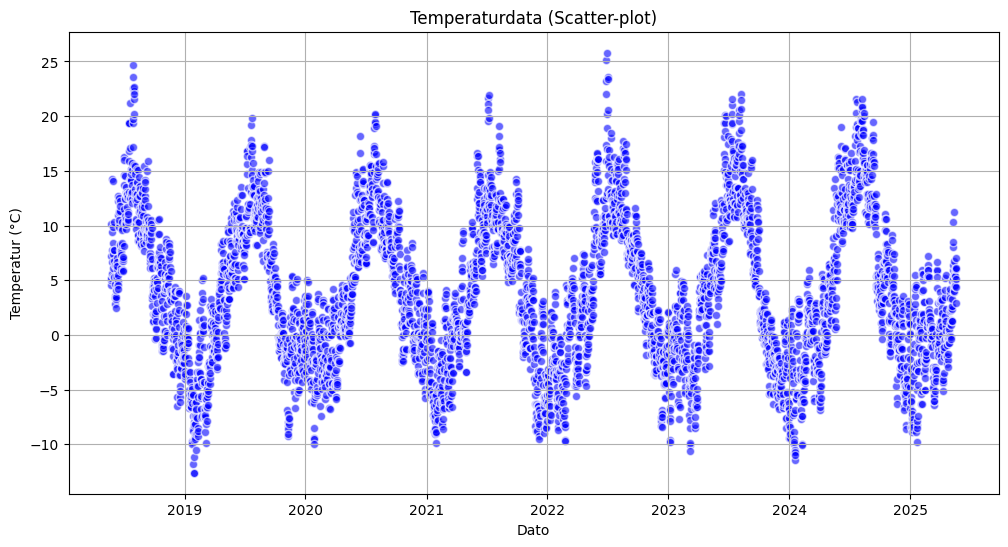

In [4]:
# Scatter-plot for temperaturdata
plt.figure(figsize=(12, 6))
plt.scatter(temperature_data['referenceTime'], temperature_data['value'], color='blue', alpha=0.6, edgecolors='w')
plt.title('Temperaturdata (Scatter-plot)')
plt.xlabel('Dato')
plt.ylabel('Temperatur (°C)')
plt.grid(True)
plt.show()

Et spredningsdiagram (scatterplot) er et effektivt verktøy for å visualisere data over tid. I motsetning til et linjediagram, kan scatterplot gi et renere uttrykk siden det ikke trekkes linjer mellom datapunktene, noe som kan redusere visuell støy. Vi valgte å bruke scatterplot av samme grunn som linjediagrammet – det er en anerkjent metode for datavisualisering som gir en tydelig og oversiktlig fremstilling. En fordel med scatterplot er at dersom det mangler data for en måned, vil det ikke bli tegnet en linje mellom datapunktene – noe som ville skjedd i et linjediagram og potensielt gitt et misvisende bilde av utviklingen.

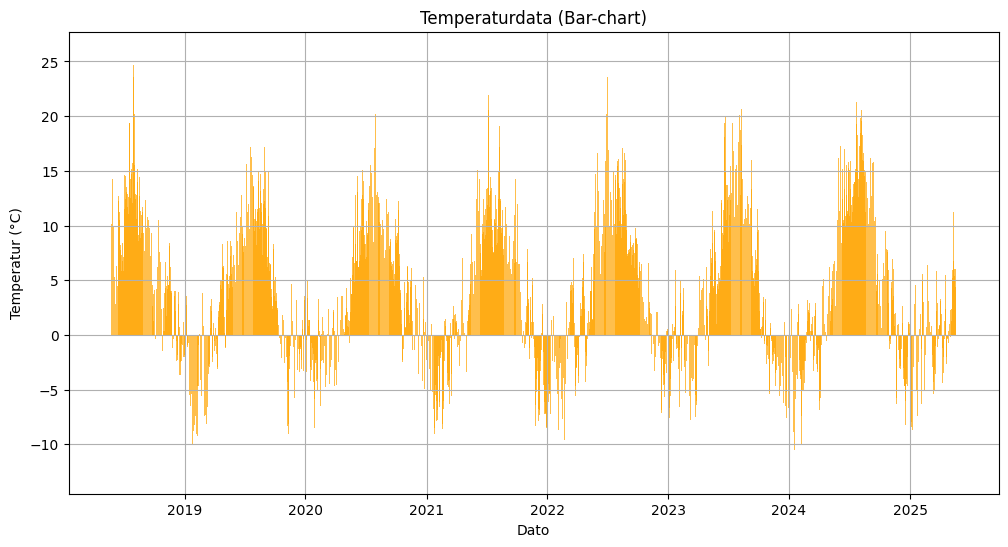

In [5]:
# Bar-chart for temperaturdata
plt.figure(figsize=(12, 6))
plt.bar(temperature_data['referenceTime'], temperature_data['value'], color='orange', alpha=0.7)
plt.title('Temperaturdata (Bar-chart)')
plt.xlabel('Dato')
plt.ylabel('Temperatur (°C)')
plt.grid(True)
plt.show()

Søylediagram egner seg mindre godt i denne sammenhengen, da det kan gi inntrykk av at temperaturverdiene er uavhengige av hverandre og ikke følger en kontinuerlig utvikling over tid. Vi valgte likevel å inkludere et søylediagram ettersom det ble etterspurt tre ulike visualiseringstyper, og vi vurderte at både linjediagram og scatterplot allerede dekket de mest egnede fremstillingene.

In [6]:
# Gruppér nedbørsdata ukentlig
precipitation_data['referenceTime'] = pd.to_datetime(precipitation_data['referenceTime'], errors='coerce').dt.tz_localize(None)
precipitation_data['Week'] = precipitation_data['referenceTime'].dt.to_period('W')
weekly_precipitation = precipitation_data.groupby('Week')['value'].mean().reset_index()

# Konverter 'Week' tilbake til datetime for plotting
weekly_precipitation['Week'] = weekly_precipitation['Week'].dt.to_timestamp()

# Oppdater plottet med ukentlige data som stolpediagram
fig_precip = go.Figure()
fig_precip.add_trace(go.Bar(
    x=weekly_precipitation['Week'],
    y=weekly_precipitation['value'],
    name='Ukentlig Nedbør',
    marker=dict(color='#1f77b4')
))

mean_precip = weekly_precipitation['value'].mean()
median_precip = weekly_precipitation['value'].median()

fig_precip.add_trace(go.Scatter(
    x=weekly_precipitation['Week'],
    y=[mean_precip] * len(weekly_precipitation['Week']),
    mode='lines',
    line=dict(dash='dash', color='rgba(31, 119, 180)'),
    name='Gjennomsnittsnedbør'
))

fig_precip.update_layout(
    title=f"Nedbør over tid (Ukentlig)<br>Gjennomsnitt: {mean_precip:.2f} mm, Median: {median_precip:.2f} mm",
    xaxis_title="Dato",
    yaxis_title="Nedbør (mm)"
)

fig_precip.show()

# Leser data fra de separate CSV-filene
wind_speed_data['referenceTime'] = pd.to_datetime(wind_speed_data['referenceTime'], errors='coerce').dt.tz_localize(None)
humidity_data['referenceTime'] = pd.to_datetime(humidity_data['referenceTime'], errors='coerce').dt.tz_localize(None)

# Gruppér vindhastighetsdata ukentlig
wind_speed_data['Week'] = wind_speed_data['referenceTime'].dt.to_period('W')
weekly_wind_speed = wind_speed_data.groupby('Week')['value'].mean().reset_index()
weekly_wind_speed['Week'] = weekly_wind_speed['Week'].dt.to_timestamp()

# Plotter ukentlig vindhastighet som linjediagram
fig_wind = go.Figure()
fig_wind.add_trace(go.Scatter(
    x=weekly_wind_speed['Week'],
    y=weekly_wind_speed['value'],
    mode='lines',
    name='Ukentlig Vindhastighet',
    line=dict(color='#1f77b4')
))

mean_wind = weekly_wind_speed['value'].mean()
median_wind = weekly_wind_speed['value'].median()

fig_wind.add_trace(go.Scatter(
    x=weekly_wind_speed['Week'],
    y=[mean_wind] * len(weekly_wind_speed['Week']),
    mode='lines',
    line=dict(dash='dash', color='rgba(31, 119, 180)'),
    name='Gjennomsnittsvindhastighet'
))

fig_wind.update_layout(
    title=f"Vindhastighet over tid (Ukentlig)<br>Gjennomsnitt: {mean_wind:.2f} m/s, Median: {median_wind  :.2f} m/s",
    xaxis_title="Dato",
    yaxis_title="Vindhastighet (m/s)"
)

fig_wind.show()

# Gruppér luftfuktighetsdata ukentlig
humidity_data['Week'] = humidity_data['referenceTime'].dt.to_period('W')
weekly_humidity = humidity_data.groupby('Week')['value'].mean().reset_index()
weekly_humidity['Week'] = weekly_humidity['Week'].dt.to_timestamp()

# Plotter ukentlig luftfuktighet som linjediagram
fig_humidity = go.Figure()
fig_humidity.add_trace(go.Scatter(
    x=weekly_humidity['Week'],
    y=weekly_humidity['value'],
    mode='lines',
    name='Ukentlig Luftfuktighet',
    line=dict(color='#1f77b4')
))

mean_humidity = weekly_humidity['value'].mean()
median_humidity = weekly_humidity['value'].median()

fig_humidity.add_trace(go.Scatter(
    x=weekly_humidity['Week'],
    y=[mean_humidity] * len(weekly_humidity['Week']),
    mode='lines',
    line=dict(dash='dash', color='rgba(31, 119, 180)'),
    name='Gjennomsnittlig luftfuktighet'
))

fig_humidity.update_layout(
    title=f"Luftfuktighet over tid (Ukentlig)<br>Gjennomsnitt: {mean_humidity:.2f} %, Median: {median_humidity:.2f} %",
    xaxis_title="Dato",
    yaxis_title="Relativ luftfuktighet (%)"
)

fig_humidity.show()